# Dataset

Eight target categories are available in this dataset: Albacore tuna, Bigeye tuna, Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other (meaning that there are fish present but not in the above categories), and No Fish (meaning that no fish is in the picture). Each image has only one fish category, except that there are sometimes very small fish in the pictures that are used as bait. 

The dataset was compiled by The Nature Conservancy in partnership with Satlink, Archipelago Marine Research, the Pacific Community, the Solomon Islands Ministry of Fisheries and Marine Resources, the Australia Fisheries Management Authority, and the governments of New Caledonia and Palau.

The original objective of this datset is to be used in a kaggle competition to successfully classify each of the target fish. But I assume the actual business case is to stop illegal fishing and overfishing of threatened and endangered fish (+ sharks).

![alt text](https://kaggle2.blob.core.windows.net/competitions/kaggle/5568/media/species-ref-key.jpg "Target Fish")

In [1]:
from sklearn import datasets as ds
import pandas as pd
import numpy as np
import os, os.path
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
import colorsys
import copy
from PIL import Image

from sklearn.decomposition import KernelPCA
import zipfile

import skimage
from skimage import io

from skimage.transform import resize
from random import shuffle
import seaborn as sns

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np

import re


# define X and y here.
import glob2
from PIL import Image
import matplotlib.image as mpimg
from sklearn.metrics import roc_curve, auc


from scipy import interp

In [2]:
image_data = []
image_labels = []

directory = "./train"
os.walk(directory)
folder_names = [x[0] for x in os.walk(directory)]
del folder_names[0]
print(folder_names)
categories = {category.replace('./train\\', '') for category in folder_names}
print(categories)

['./train/ALB', './train/BET', './train/DOL', './train/LAG', './train/NoF', './train/OTHER', './train/SHARK', './train/YFT']
{'./train/DOL', './train/BET', './train/OTHER', './train/NoF', './train/SHARK', './train/LAG', './train/ALB', './train/YFT'}


In [3]:
# import os
# import shutil
# max = 50
# i = 0
# flag = False
# labels = []
# for sub in os.listdir('./train'):
#     if(sub == '.DS_Store'):
#         continue
#     for file in os.listdir('./train/'+sub):
#         labels.append(sub);
#         shutil.copy2('./train/'+ sub + '/'+ file,'./train2')
#         i += 1
#         if(i == max):
#             flag = True
#             break
#     if(flag == True):
#         i = 0
# fish_image_files = glob2.glob('train2/*.jpg')

In [4]:
%%time
fish_image_files = glob2.glob('train/**/*.jpg')
size = 300, 300

igs = np.array([skimage.transform.resize(skimage.io.imread(fname, as_grey=True, plugin=None, flatten=None),(300,300))
                                         for fname in fish_image_files])

CPU times: user 4min 44s, sys: 52.8 s, total: 5min 37s
Wall time: 10min 47s


In [5]:
image_labels = []
for fname in fish_image_files:
    image_labels.append(re.sub('/img.*', '', fname.replace('train/', '')))


In [6]:
#train_data = igs.astype('float32')
#train_data = train_data / 255
#igs_pca = train_data.reshape(igs.shape[0], (train_data.shape[1]*train_data.shape[2]))
X = igs
y = np.asarray(image_labels)

### Splitting the data

We chose to do a single 80/20 train test split. This is because of the long train times. A k-fold split would be impractical and doing a shuffle split of a large size is also impractical. We may be able to do 2 or 3 shuffle splits, but that does not do much more for us than having 1 shuffle split.

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
indexes = sss.split(X, y)

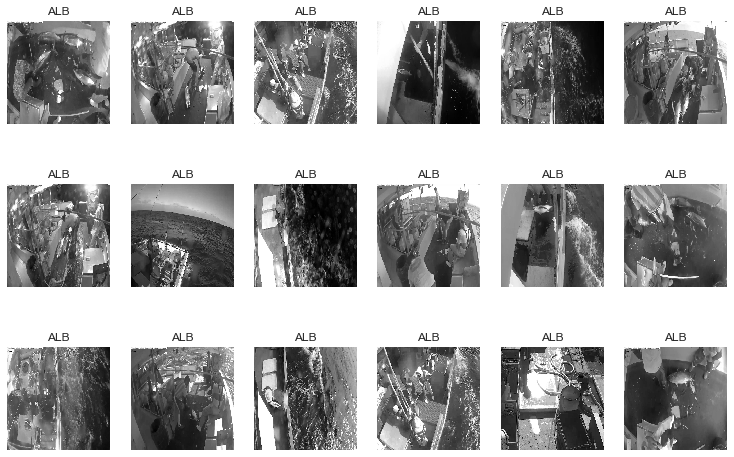

In [8]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, y, 8, 8) # defaults to showing a 3 by 6 subset of the images

The fish represent a small percentage of the overall picture. The lighting conditions are different as well. (fish caught during the night vs fish caught during the day).

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

Using TensorFlow backend.


'2.0.3'

In [10]:
NUM_CLASSES = 8
#vectorize images
X = X.reshape(X.shape[0], 90000)

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
list(le.classes_)
y = le.transform(y)

# Cost Matrix and Custom Scorer

In [13]:
# ask how to make this all under 1
cost_matrix = np.matrix([[0,1,1,1,1,1,1,1],
[1.5,0,1.5,1.5,1.5,1.5,1.5,1.5],
[.5,0,.5,.5,.5,.5,.5,.5],
[1,1,1,0,1,1,1,1],
[1,1,1,1,0,1,1,1],
[1,1,1,1,1,0,1,1],
[2,2,2,2,2,2,0,2],
[1.25,1.25,1.25,1.25,1.25,1.25,1.25,0]])

def get_confusion_costTot(confusion_matrix, cost_matrix):
    score = np.sum(confusion_matrix*cost_matrix)
    return score

We decided to create a custom scorer with a cost matrix. This is because each of the misclassifications should have different costs associated with them. For instance many sharks are endangered and protected, so misclassifying a shark is worth more than misclassifying a common species, such as the dolphinfish. These are the metrics taken into account for deciding the worth of classifying and misclassifying each of the classes.

'ALB' = Albacore tuna. Common fish.

'BET' = Bigeye tuna. Threatened fish.

'DOL' = Dolphinfish. Extremely common fish.

'LAG' = Opah, Moonfish. Not much is known about this species as they are Deep water fishes.

'SHARK' = Various sharks. Endangered and most illegally fished.

'YFT' = Yellowfin tuna. Threatened fish, but not as much as the bigeye tuna.

In [14]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
        
        aucs = []
        fprs = []
        tprs = []
        #classifier.fit(X_train,y_train)
        #     probas = pipe_lr.fit(X_train[train],
        #                          y_train[train]).predict_proba(X_train[test])
        #     #ind_yhat = classifier.predict(X_test)
        
        #ind_yhat = np.argmax(cnn.predict_proba(np.expand_dims(X_train, axis=1)),axis=1)
        
        ind_yhat = cnn.predict_proba(np.expand_dims(X_test, axis=1))
        #ind_yhat = np.array(yhat_cnn)
        #ind_yhat = yhat_cnn
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        all_tpr = []
        perclass_mean_tpr = 0.0
        roc_auc = 0
        #classes = np.unique(y_train)
        labels2 = np.unique(y_test)

        classes = labels2
            # get the mean fpr and tpr, per class
        ind = 0
        for j in classes:
            #print(j)
            fpr, tpr, thresholds = roc_curve(y_test,
                                             ind_yhat[:,j-1],
                                             pos_label=j-1)
            perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
            perclass_mean_tpr[0] = 0.0 
            roc_auc += auc(fpr, tpr)
            fprs.append(fpr)
            tprs.append(tpr)
            aucs.append(auc(fpr, tpr))
            ind += 1
        plt.figure()
        for i in range(0,5):
            plt.plot(fprs[i],tprs[i],label='Class %d (area = %0.2f)'
                       % (i+1, aucs[i]))
            plt.legend(loc='best')
        plt.title("Convolutional Network ROC")

        plt.show()
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))
        aucs = []
        fprs = []
        tprs = []
        #classifier.fit(X_train,y_train)
        #     probas = pipe_lr.fit(X_train[train],
        #                          y_train[train]).predict_proba(X_train[test])
        #     #ind_yhat = classifier.predict(X_test)
        
        #ind_yhat = np.argmax(cnn.predict_proba(np.expand_dims(X_train, axis=1)),axis=1)
        arr = np.expand_dims(X_test, axis=1)
        ind_yhat_mlp = mlp.predict_proba(arr.reshape(arr.shape[0],arr.shape[2]))
        
        #ind_yhat_mlp = yhat_mlp
        #print(ind_yhat_mlp)
        #ind_yhat = yhat_cnn
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        all_tpr = []
        perclass_mean_tpr = 0.0
        roc_auc = 0
        #classes = np.unique(y_train)
            # get the mean fpr and tpr, per class
        ind = 0
        for j in classes:
            #print(j)
            fpr, tpr, thresholds = roc_curve(y_test,
                                             ind_yhat_mlp[:,j-1],
                                             pos_label=j-1)
            perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
            perclass_mean_tpr[0] = 0.0 
            roc_auc += auc(fpr, tpr)
            fprs.append(fpr)
            tprs.append(tpr)
            aucs.append(auc(fpr, tpr))
            ind += 1
        plt.figure()
        for i in range(0,5):
            plt.plot(fprs[i],tprs[i],label='Class %d (area = %0.2f)'
                       % (i+1, aucs[i]))
            plt.legend(loc='best')
        plt.title("MLP ROC")

        plt.show()

## MLP and First CNN

736/756 [============================>.] - ETA: 0s

/Users/vantran/anaconda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


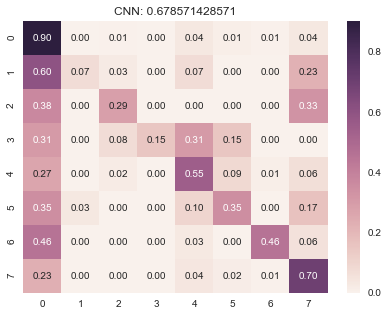

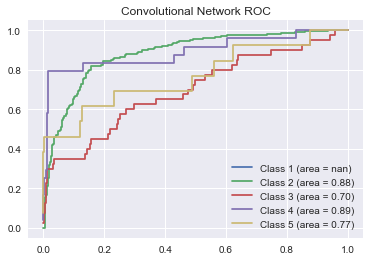

736/756 [============================>.] - ETA: 0s

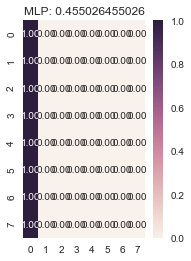

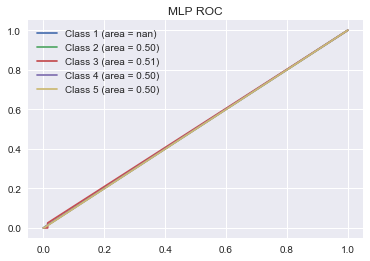

756/756 [==============================] - 1s     


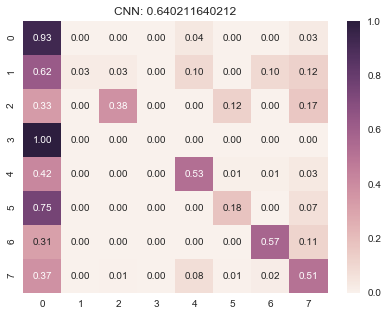

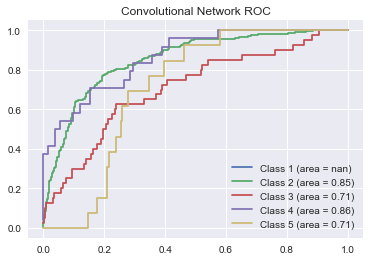

756/756 [==============================] - 1s     


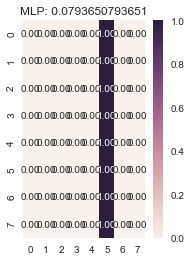

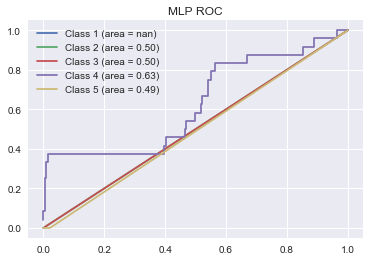

CPU times: user 47min 3s, sys: 8min 58s, total: 56min 2s
Wall time: 1h 21min 45s


In [15]:
%%time
for train_index, test_index in sss.split(X, y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

    # make a 3 layer keras MLP
    mlp = Sequential()
    mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add( Dense(NUM_CLASSES) )
    mlp.add( Activation('softmax') )

    mlp.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    mlp.fit(X_train, y_train_ohe, 
            batch_size=32, epochs=50, 
            shuffle=True, verbose=0)
    cnn = Sequential()
    cnn.add(Reshape((1,300,300), input_shape=(1,90000)))
    cnn.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,300,300)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(10, 10), data_format="channels_first"))
    # add one layer on flattened output
    cnn.add(Flatten())
    cnn.add(Dense(NUM_CLASSES))
    cnn.add(Activation('softmax'))

    # Let's train the model 
    cnn.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
            batch_size=32, epochs=50, 
            shuffle=True, verbose=0)
    compare_mlp_cnn(cnn,mlp,X_test,y_test)

Our MLP is being overtrained. The CNN performs better because maxpooling leaves out 3 of the 4 weights acting as a dropout and helps keep our model from becoming overtrained. For some reason we have nan area for our first class. Also we are not plotting all of our classes on the ROC. We want to change the ROC graphing function, but due to training time being ~6 hours this is not feasible. We accidentally forgot to change the number of classes from 5 to 8.

## CNN 2: Increased kernel size from 2x2 to 3x3

756/756 [==============================] - 2s     

/Users/vantran/anaconda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


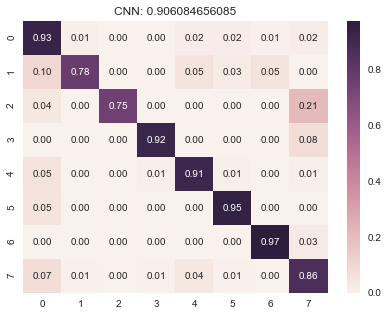

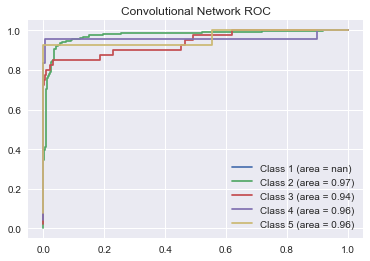

756/756 [==============================] - 8s     

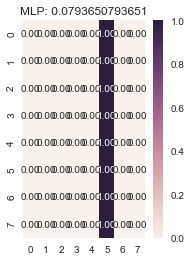

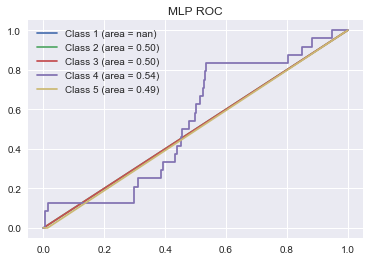

756/756 [==============================] - 6s     

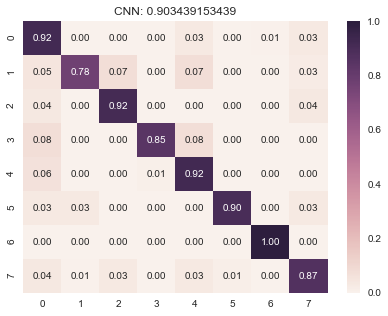

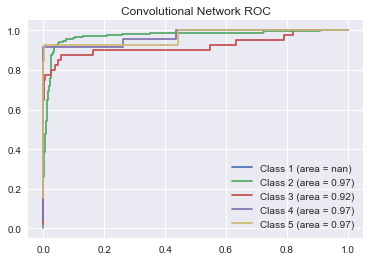

736/756 [============================>.] - ETA: 0s

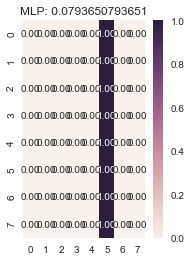

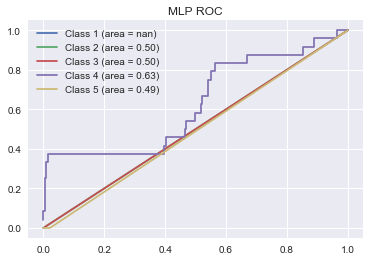

CPU times: user 48min 4s, sys: 5min 23s, total: 53min 28s
Wall time: 1h 26min 50s


In [16]:
%%time
for train_index, test_index in sss.split(X, y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
    # changes: 
    #    1. increased kernel size
    cnn2 = Sequential()
    cnn2.add(Reshape((1,300,300), input_shape=(1,90000)))
    cnn2.add(Conv2D(filters=16, kernel_size= (3, 3), padding='same', input_shape=(1,300,300)))
    cnn2.add(Activation('relu'))
    cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    # add one layer on flattened output
    cnn2.add(Flatten())
    cnn2.add(Dense(NUM_CLASSES))
    cnn2.add(Activation('softmax'))

    # Let's train the model 
    cnn2.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
            batch_size=32, epochs=50, 
            shuffle=True, verbose=0)

    compare_mlp_cnn(cnn2,mlp,X_test,y_test)

Increasing the kernel size allows us to train filters of a more diverse transformation set on our data. This architecture performed much better than the previous architecture. We can see that this model misclassifies class 0 (Albacore tuna) much less than the first model.

## CNN 3: Increased Kernel Size and +1 Convolutional layer

756/756 [==============================] - 2s     

/Users/vantran/anaconda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


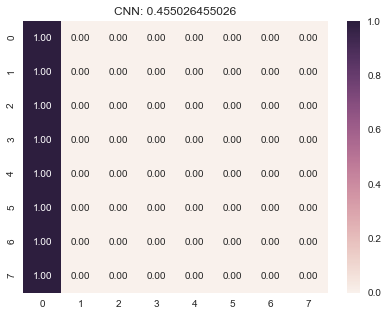

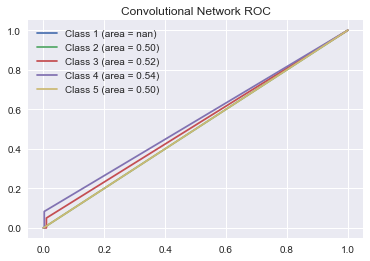

756/756 [==============================] - 2s     

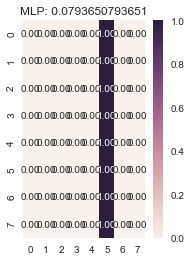

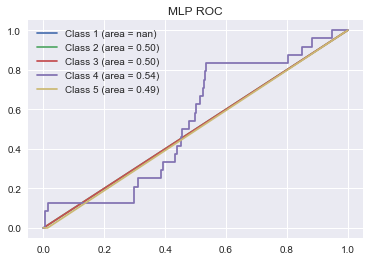

756/756 [==============================] - 3s     

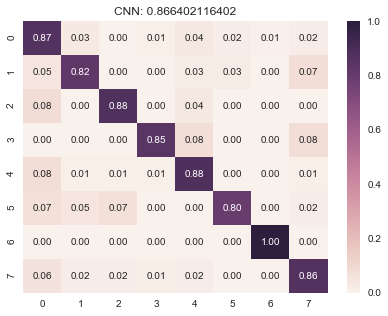

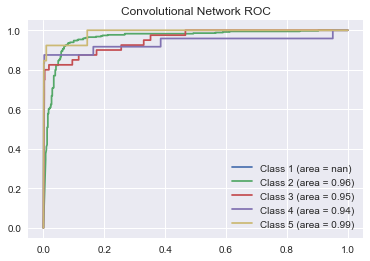

736/756 [============================>.] - ETA: 0s

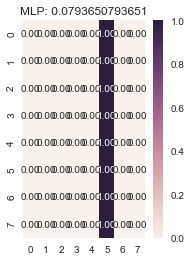

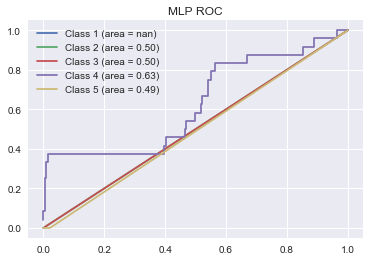

CPU times: user 1h 14min 40s, sys: 6min 37s, total: 1h 21min 17s
Wall time: 1h 28min 43s


In [17]:
%%time
for train_index, test_index in sss.split(X, y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
    # changes: 
    #    1. increased kernel size
    #    2. add another conv/pool layer 
    cnn3 = Sequential()
    cnn3.add(Reshape((1,300,300), input_shape=(1,90000)))

    num_filt_layers = [32, 32]
    for num_filters in num_filt_layers:
        cnn3.add(Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same'))
        cnn3.add(Activation('relu'))
        cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))


    # add one layer on flattened output
    cnn3.add(Flatten())
    cnn3.add(Dense(NUM_CLASSES))
    cnn3.add(Activation('softmax'))

    # Let's train the model 
    cnn3.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    cnn3.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
            batch_size=32, epochs=50, 
            shuffle=True, verbose=0)

    compare_mlp_cnn(cnn3,mlp,X_test,y_test)

Our first trained model was overfit and misclassified everything as class 0 and the second performed more or less the same as the models in the second CNN architecture. We can see that this data is easily overfit. Mostly because of a large class imbalance. (Largest class is ~1700, smallest class is ~64)

## CNN 4: Increased kernel size, +1 Convolutional layer, Flattened and added relu layer.

756/756 [==============================] - 2s     

/Users/vantran/anaconda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


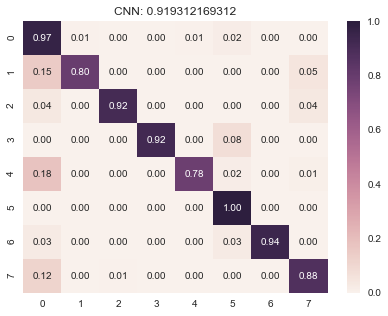

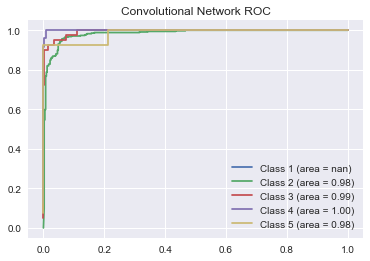

736/756 [============================>.] - ETA: 0s

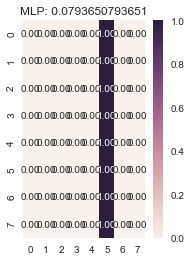

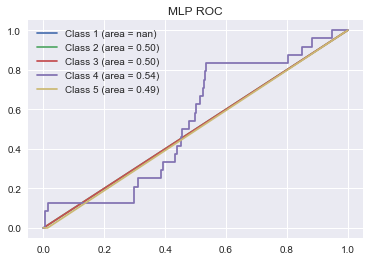

756/756 [==============================] - 3s     

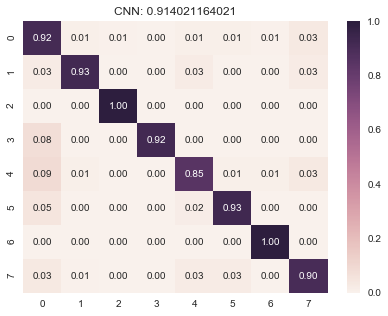

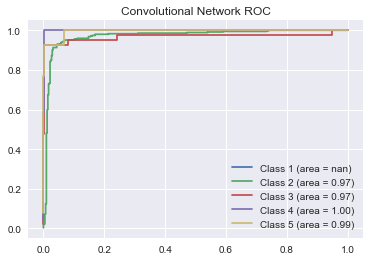

756/756 [==============================] - 0s     


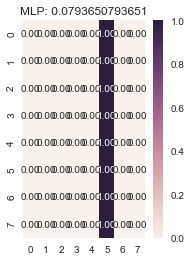

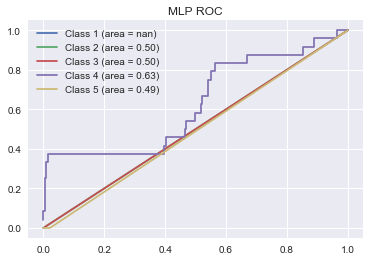

CPU times: user 1h 7min 48s, sys: 9min 39s, total: 1h 17min 27s
Wall time: 1h 26min 10s


In [18]:
%%time
for train_index, test_index in sss.split(X, y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
    # changes: 
    #    1. increased kernel size
    #    2. add another conv/pool layer with increasing num filters
    #    3. add more layers once flattened
    cnn4 = Sequential()
    cnn4.add(Reshape((1,300,300), input_shape=(1,90000)))

    num_filt_layers = [24, 48]
    for num_filters in num_filt_layers:
        cnn4.add(Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same'))
        cnn4.add(Activation('relu'))
        cnn4.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))


    # add one layer on flattened output
    cnn4.add(Flatten())
    cnn4.add(Dense(100))
    cnn4.add(Activation('relu'))
    cnn4.add(Dense(NUM_CLASSES))
    cnn4.add(Activation('softmax'))

    # Let's train the model 
    cnn4.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    cnn4.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
            batch_size=64, epochs=50, 
            shuffle=True, verbose=0)

    compare_mlp_cnn(cnn4,mlp,X_test,y_test)

This CNN architecture performed better than all of the previous architectures. We can see that the model still has the same problems (misclassifying other classes as class 0), but overall the effect of these problems are less.

# Exceptional Work 

### Analyzing filters used

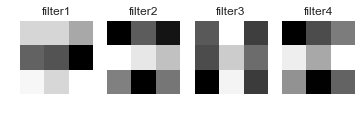

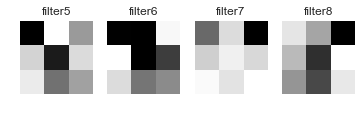

In [23]:
max_plots = 4
counter = 1
for layer in cnn4.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
            plt.title('filter' + str(counter))
            counter = counter +1
        plt.show()

Filters 1, 2, 4, 7 look like horizontal edge detectors.

Filters 3 looks like vertical edge detectors.

Filters 5, 6, 8 look like filters trained to find randomness.